# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import inflection
import math
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image 
from IPython.core.display import HTML
import datetime

## 0.1 Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [18, 8]
    plt.rcParams['font.size'] = 20
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    jupyter_settings()
    
    
def reduce_mem_usage(df):
    """ 
    iterate through all the columns of a dataframe and 
    modify the data type to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage of dataframe is {:.2f}' 
                     'MB').format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max <\
                  np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max <\
                   np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max <\
                   np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max <\
                   np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max <\
                   np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max <\
                   np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')    
            end_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage after optimization is: {:.2f}' 
                              'MB').format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) 
                                             / start_mem))
    
    return df    

## 0.2 Loading Data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv',low_memory=False)
df_store_raw = pd.read_csv('data/store.csv',low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw,df_store_raw, how='left', on='Store')

# 1.0 Data Description

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:


cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase,cols_old))

df1.columns = cols_new

## 1.2 Data Dimensions

In [7]:
print(f'Number of rows {df1.shape[0]}')
print(f'Number of columns {df1.shape[1]}')

Number of rows 1017209
Number of columns 18


## 1.3 Data Type

In [8]:

df1['date'] = pd.to_datetime(df1['date'])

In [9]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [11]:
#competition_distance    
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month  
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)

#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)

#promo2_since_week   
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)


#promo2_since_year   

df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis=1)




In [12]:
#promo_interval  

month_map = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

df1['promo_interval'].fillna(0,inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0,axis=1)

In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Data Types

In [14]:
# competiton 
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

#promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistics 

In [15]:


num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])



## 1.7.1 Numerical Attributes

In [16]:
#Central tendency -mean, median 

ct1= pd.DataFrame(num_attributes.apply(np.mean)).T
ct2= pd.DataFrame(num_attributes.apply(np.median)).T

#dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
metrics = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
metrics.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']

In [17]:
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Categorical attributes

In [18]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [19]:
jupyter_settings()


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


KeyboardInterrupt: 

<AxesSubplot:xlabel='assortment', ylabel='sales'>

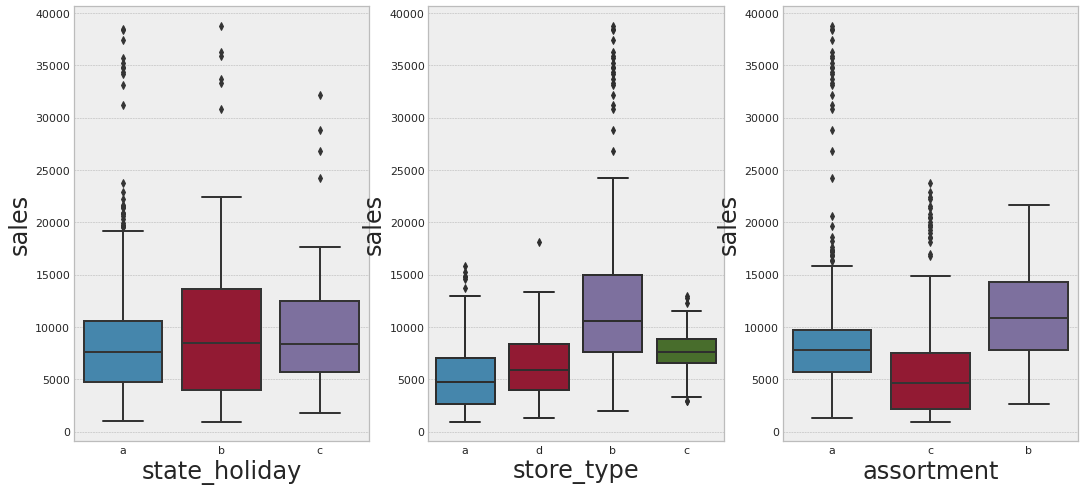

In [20]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

## 2.0 FEATURE ENGINEERING

In [21]:
df2= df1.copy()

## 2.1 Mind map hypotheses

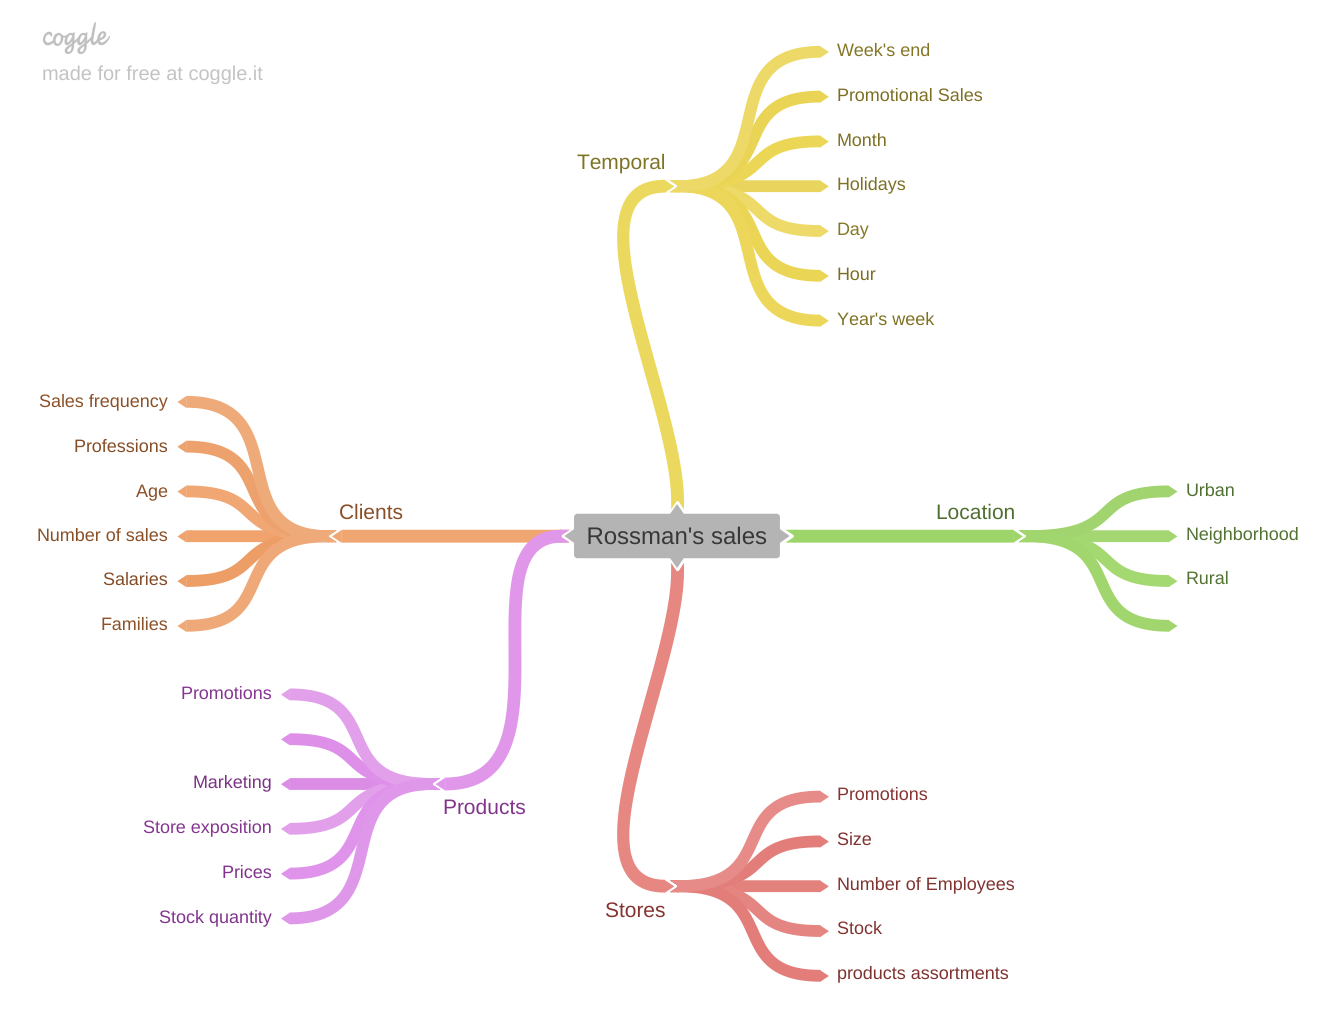

In [22]:
Image('img/mind_map.png')

### 2.1.1 Store hypotheses

**1-** Stores with a higher number of employees probably sell more

**2-** Stores with a higher number of stock probably sell more

**3-** Bigger stores probably sell more

**4-** Smaller stores probably sell less

**5-** Stores with a bigger products assortments probably sell more

**6-** Stores with a big amount of competitors probably sell less

**7-** Stores with competitors for a longer period of time probably sell more



### 2.1.2 Product hypotheses

**1-** Stores that invests more in marketing probably sell more

**2-** Stores with a bigger amount of products windows probably sell more

**3-** Stores with cheaper prices probably sell more

**4-** Stores with bigger time promotions probably sell more

**5-** Stores with active promotions for longer period of time probably sell more

**6-** Stores with a bigger amount of promotional days probably sell more

**7-** Stores with active promotions for longer period of time probably sell more

**8-** Stores with new consecutive promotions probably sell more


### 2.1.3 Temporal hypotheses

**1-** Stores where there's a bigger amount of holidays probably sell less

**2-** Stores open in the second semester of the year probably sell more

**3-** Stores that are open in week ends probably sell more

**4-** Stores probably sell more after each 10th day of month

**5-** Stores probably sell less in week ends

**6-** Stores probably sell less in scholar holidays

**7-** Stores open in Christmas holiday probably sell more

**8-** Stores that were open early probably sell more


## 2.2 Final list of hypotheses

**1-** Stores with a bigger products assortments probably sell more

**2-** Stores with a big amount of competitors probably sell less

**3-** Stores with competitors for a longer period of time probably sell more

**4-** Stores with active promotions for longer period of time probably sell more

**5-** Stores with a bigger amount of promotional days probably sell more

**6-** Stores with active promotions for longer period of time probably sell more

**7-** Stores with new consecutive promotions probably sell more

**8-** Stores open in Christmas holiday probably sell more

**9-** Stores that were open early probably sell more

**10-** Stores open in the second semester of the year probably sell more

**11-** Stores probably sell more after each 10th day of month

**12-** Stores probably sell less in week ends

**13-** Stores probably sell less in scholar holidays




## 2.3 Feature Engineering

In [ ]:
reduce_mem_usage(df2)

In [23]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')




<ipython-input-23-6034d6dc66f8>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [24]:
#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],month= x['competition_open_since_month'],day=1),axis=1)
df2['competition_time_month'] = ((df2['date']-df2['competition_since'])/30).apply(lambda x: x.days).astype(int)






In [25]:
#promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )
datetime.datetime.strptime

<function datetime.strptime>

In [26]:
#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == "a" else 'extra' if x == 'b' else 'extended') 


#state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


# 3.0 Variable Filter

In [28]:
df3=df2.copy()

In [29]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Rows filter

In [31]:
df3 = df3[(df3['open'] !=0 ) & (df3['sales']) >0]


## 3.2 Columns selection

In [37]:
cols_drop = ['customers','open','promo_interval','month_map']

df3 = df3.drop(cols_drop,axis= 1)

In [39]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')